<a href="https://colab.research.google.com/github/cyrilgabriele/AI1/blob/main/Lab3_Task3_Cyril_Ardi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Q-Learning Integration:**

For the final task, you should replace the Monte Carlo method used and extended in the first two tasks with the Q-Learning algorithm, as introduced last week. This will allow you to compare the performance of Q-Learning with the Monte Carlo approach and observe how the learning process differs.

In [ ]:
from collections import defaultdict, namedtuple
from enum import Enum
from typing import Tuple, List
import random
from IPython.display import clear_output
import copy
import time
import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:
Point = namedtuple('Point', ['x', 'y'])
class Direction(Enum):
  NORTH = "⬆"
  EAST = "⮕"
  SOUTH = "⬇"
  WEST = "⬅"

  @classmethod
  def values(self):
    return [v for v in self]



class SimpleGridWorld(object):

  def __init__(self, width: int = 5, height: int = 5, debug: bool = False):
    self.width = width
    self.height = height
    self.debug = debug
    self.action_space = [d for d in Direction]
    self.reset()

  def reset(self):
    self.cur_pos = Point(x=0, y=(self.height - 1))
    self.goal = Point(x=(self.width - 1), y=0)
    # If debug, print state
    if self.debug:
      print(self)
    return self.cur_pos, 0, False

  def step(self, action: Direction):
    # Depending on the action, mutate the environment state
    if action == Direction.NORTH:
      self.cur_pos = Point(self.cur_pos.x, self.cur_pos.y + 1)
    elif action == Direction.EAST:
      self.cur_pos = Point(self.cur_pos.x + 1, self.cur_pos.y)
    elif action == Direction.SOUTH:
      self.cur_pos = Point(self.cur_pos.x, self.cur_pos.y - 1)
    elif action == Direction.WEST:
      self.cur_pos = Point(self.cur_pos.x - 1, self.cur_pos.y)
    # Check if out of bounds
    if self.cur_pos.x >= self.width:
      self.cur_pos = Point(self.width - 1, self.cur_pos.y)
    if self.cur_pos.y >= self.height:
      self.cur_pos = Point(self.cur_pos.x, self.height - 1)
    if self.cur_pos.x < 0:
      self.cur_pos = Point(0, self.cur_pos.y)
    if self.cur_pos.y < 0:
      self.cur_pos = Point(self.cur_pos.x, 0)

    # If at goal, terminate
    is_terminal = self.cur_pos == self.goal

    # Constant -1 reward to promote speed-to-goal

    reward = -1

    # If debug, print state
    if self.debug:
      print(self)

    return self.cur_pos, reward, is_terminal

  def peek(self, action: Direction):
  # get next position without mutating the environment
    if action == Direction.NORTH:
      new_pos = Point(self.cur_pos.x, self.cur_pos.y + 1)
    elif action == Direction.EAST:
       new_pos = Point(self.cur_pos.x + 1, self.cur_pos.y)
    elif action == Direction.SOUTH:
       new_pos = Point(self.cur_pos.x, self.cur_pos.y - 1)
    elif action == Direction.WEST:
      new_pos = Point(self.cur_pos.x - 1, self.cur_pos.y)
    # Check if out of bounds
    if new_pos.x >= self.width:
      new_pos = Point(self.width - 1, self.cur_pos.y)
    if new_pos.y >= self.height:
      new_pos = Point(self.cur_pos.x, self.height - 1)
    if new_pos.x < 0:
      new_pos = Point(0, self.cur_pos.y)
    if new_pos.y < 0:
      new_pos = Point(self.cur_pos.x, 0)
    return new_pos

  def __repr__(self):
    res = ""
    for y in reversed(range(self.height)):
      for x in range(self.width):
        if self.goal.x == x and self.goal.y == y:
          if self.cur_pos.x == x and self.cur_pos.y == y:
            res += "@"
          else:
            res += "o"
          continue
        if self.cur_pos.x == x and self.cur_pos.y == y:
          res += "x"
        else:
          res += "_"
      res += "\n"
    return res


In [ ]:
class Agent(object):
  def __init__(self, env: object, num_episodes=1000, min_lr=0.1,
                 min_epsilon=0.1, discount=1.0, decay=10):

    self.num_episodes = num_episodes
    self.min_lr = min_lr
    self.min_epsilon = min_epsilon
    self.discount = discount
    self.decay = decay
    self.env = env

    self.steps = np.zeros(self.num_episodes)

    # Create a Q-table dictionary and initialize it with all 0.0
    self.Q_table = defaultdict(lambda: defaultdict(float))
    for x in range(self.env.width):
      for y in range(self.env.height):
        state = Point(x, y)
        for action in self.env.action_space:
            self.Q_table[state][action] = 0.0


  def choose_action(self, state):
    if (np.random.random() < self.epsilon):
        return random.choice(self.env.action_space)
    else:
        return max(self.env.action_space, key=lambda a: self.Q_table[state][a])

  def update_q(self, state, action, reward, new_state):
    """
    Updates Q-table using the rule as described by Sutton and Barto in
    Reinforcement Learning.
    """

    self.Q_table[state][action] += (self.learning_rate *
                                    (reward
                                     + self.discount * max(self.Q_table[new_state].values())
                                     - self.Q_table[state][action]))

  def get_epsilon(self, t):
    """Gets value for epsilon. It declines as we advance in episodes."""
    # Ensures that there's almost at least a min_epsilon chance of randomly exploring
    return max(self.min_epsilon, min(1., 1. - math.log10((t + 1) / self.decay)))

  def get_learning_rate(self, t):
    """Gets value for learning rate. It declines as we advance in episodes."""
    # Learning rate also declines as we add more episodes
    return max(self.min_lr, min(1., 1. - math.log10((t + 1) / self.decay)))

  def train(self):
    """
    Trains agent making it go through the environment and choose actions
    through an e-greedy policy and updating values for its Q-table. The
    agent is trained by default for 500 episodes with a declining
    learning rate and epsilon values
    """
    # Looping for each episode
    for e in range(self.num_episodes):
        # Initializes the state
        current_state = self.env.reset()

        self.learning_rate = self.get_learning_rate(e)
        self.epsilon = self.get_epsilon(e)
        terminal = False

        # Looping for each step
        while not terminal:
            self.steps[e] += 1
            # Choose A from S
            action = self.choose_action(current_state)
            # Take action
            new_state, reward, terminal = self.env.step(action)
            # Update Q(S,A)
            self.update_q(current_state, action, reward, new_state)
            current_state = new_state

        clear_output(wait=True)
        print('episode ', e)
        print(agent.next_best_value_2d())

    print('Finished training!')

  def plot_learning(self):
    # Create subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

    # Plot steps per episode
    ax1.plot(self.steps, label='Steps per Episode', color='blue')
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Steps")

    # Plot learning rates
    ax2.plot([self.get_learning_rate(e) for e in range(self.num_episodes)], label='Learning Rate', color='green')
    ax2.set_xlabel("Episode")
    ax2.set_ylabel("Learning Rate")

    # Plot epsilons
    ax3.plot([self.get_epsilon(e) for e in range(self.num_episodes)], label='Epsilon', color='red')
    ax3.set_xlabel("Episode")
    ax3.set_ylabel("Epsilon")

    # Show legends
    ax1.legend()
    ax2.legend()
    ax3.legend()

    # Adjust spacing
    plt.tight_layout()

    # Show the plots
    plt.show()

  def next_best_value_2d(self):
    res = ""
    for y in reversed(range(self.env.height)):
      for x in range(self.env.width):
        state = Point(x, y)
        if self.env.goal.x == x and self.env.goal.y == y:
          res += "@"
        else:
          # Find the action that has the highest value
          best_action = self.choose_action(state)
          q_value = self.Q_table[state][best_action]
          res += f'{best_action.value} ({q_value:.2f})'
        res += " | "
      res += "\n"
    return res

episode  999
⬇ (-8.00) | ⬇ (-7.00) | ⮕ (-6.00) | ⮕ (-5.00) | ⬇ (-4.00) | 
⮕ (-7.00) | ⬆ (-8.00) | ⮕ (-5.00) | ⮕ (-4.00) | ⬇ (-3.00) | 
⮕ (-6.00) | ⬇ (-5.00) | ⮕ (-4.00) | ⮕ (-3.00) | ⬇ (-2.00) | 
⬅ (-6.00) | ⮕ (-4.00) | ⮕ (-3.00) | ⮕ (-2.00) | ⬇ (-1.00) | 
⬇ (-5.00) | ⮕ (-3.00) | ⮕ (-2.00) | ⮕ (-1.00) | @ | 

Finished training!


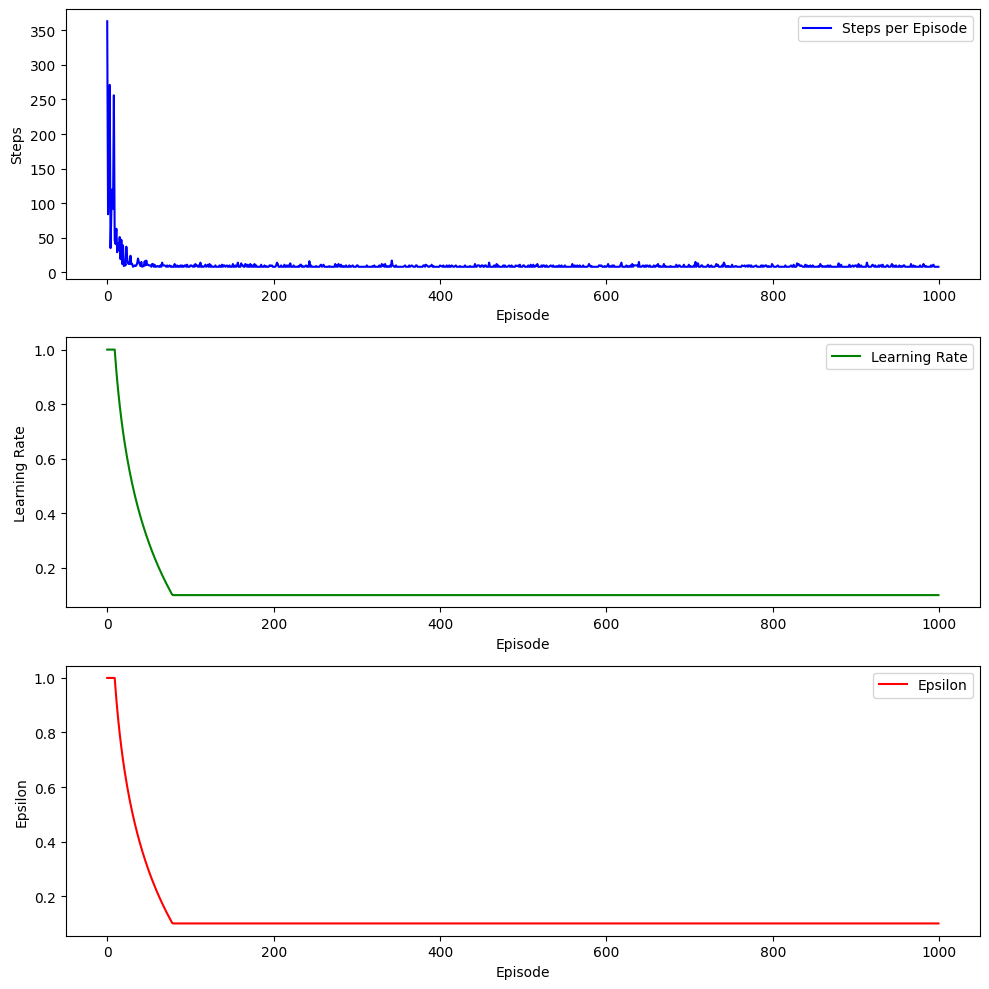

In [ ]:
env = SimpleGridWorld(debug=False)
agent = Agent(env=env)
agent.train()
agent.plot_learning()